### Phase-based encoding in pairwise neural interactions

In [1]:
import os

In [2]:
import sys

sys.path.insert(1, os.path.join("/", *os.getcwd().split("/")[:-1]))

In [3]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import scipy
import xarray as xr
from frites.core import copnorm_nd
from hoi.core import get_mi
from mne.time_frequency.tfr import tfr_array_morlet, tfr_array_multitaper
from tqdm import tqdm

from src.models import simulate_kuramoto

/opt/anaconda3/envs/test_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
dt = 0.001  # Integration time-step
fs = 1 / dt
f = 40  # Natural frequency
beta = 2.5  # Noise variance
A = np.array([[0, 1], [0, 0]]).T
ntrials = 1000
time = np.arange(-0.5, 1, 1 / fs)  # Time array
T = time.shape[0]

In [5]:
s = 8 / (2 * np.pi * f)

time_start = 0
time_end = 0.4
timestim = time[(time > time_start) & (time < time_end)] - (time_end - time_start) / 2
ind = np.where((time > time_start) & (time < time_end))[0]
gaussian = np.exp(-(timestim**2) / (2 * s**2))
coupling = np.zeros_like(time)
coupling[ind] = gaussian

# Coupling strength array (linearly spaced from 1 to 100)
CS = np.linspace(1, 100, ntrials)
seeds = np.random.randint(0, 100000, ntrials)

In [6]:
data = []

for trial in tqdm(range(ntrials)):
    data += [
        simulate_kuramoto(
            10 * A,
            np.zeros_like(A),
            coupling * CS[trial],
            f,
            fs,
            beta,
            T,
            seed=seeds[trial],
            decim=1,
        )
    ]

100%|███████████████████████████████| 1000/1000 [01:09<00:00, 14.32it/s]


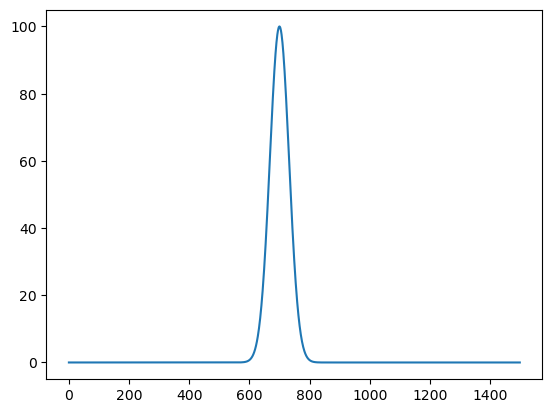

In [7]:
plt.plot(coupling * CS[trial])

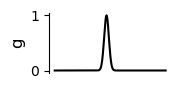

In [8]:
plt.figure(figsize=(4 / 2.54, 2 / 2.54))
ax = plt.subplot(111)
plt.plot(time, coupling, "k")
[ax.spines[key].set_visible(False) for key in ["top", "right", "bottom"]]
plt.xticks([])
plt.ylabel("g", fontsize=12)
plt.savefig("figures/coupling_strength.pdf")

(0.0, 0.4)

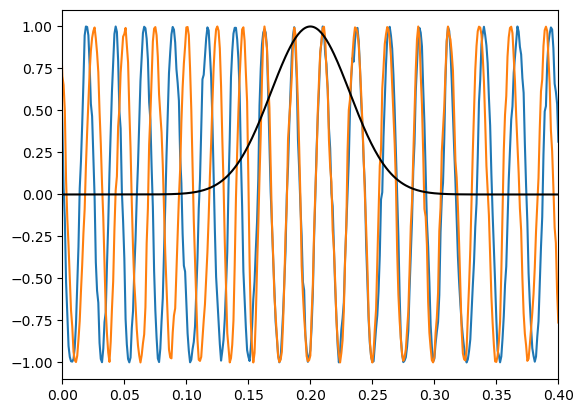

In [9]:
plt.plot(time[::1], data[-1].real.T)
plt.plot(time, coupling, "k")
plt.xlim(0, 0.4)

In [10]:
h = scipy.signal.hilbert(np.stack(data).real, axis=2)

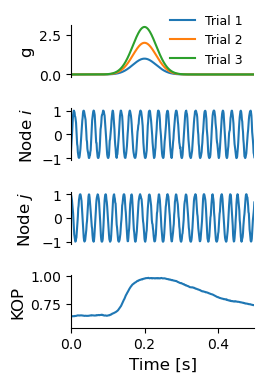

In [11]:
plt.figure(figsize=(6 / 2.54, 10 / 2.54))
ax = plt.subplot(411)
[plt.plot(time, coupling * i) for i in [1, 2, 3]]
[ax.spines[key].set_visible(False) for key in ["top", "right", "bottom"]]
plt.legend(["Trial 1", "Trial 2", "Trial 3"], fontsize=9, frameon=False)
plt.xticks([])
plt.ylabel("g", fontsize=12)
plt.xlim(0, 0.5)

ax = plt.subplot(412)
plt.plot(time[::1], data[250].real.T[:, 0])
plt.xlim(0, 0.5)
plt.xticks([])
[ax.spines[key].set_visible(False) for key in ["top", "right", "bottom"]]
plt.ylabel("Node $i$", fontsize=12)


ax = plt.subplot(413)
plt.plot(time[::1], data[250].real.T[:, 1])
plt.xlim(0, 0.5)
plt.xticks([])
[ax.spines[key].set_visible(False) for key in ["top", "right", "bottom"]]
plt.ylabel("Node $j$", fontsize=12)

ax = plt.subplot(414)
plt.plot(time[::1], np.abs(h.mean(1)).mean(0))
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("KOP", fontsize=12)
plt.xlim(0, 0.5)

plt.subplots_adjust(hspace=0.6)

plt.savefig("figures/coupling_strength_kop.pdf")

In [12]:
freqs = np.linspace(0.1, 80, 50)
W = tfr_array_morlet(
    data,
    fs / 1,
    freqs,
    n_cycles=freqs / 2,
    decim=1,
    output="complex",
    verbose=None,
)

In [13]:
Sxy = (W[:, 0] * np.conj(W[:, 1])).mean(0)
Sxx = (W[:, 0] * np.conj(W[:, 0])).mean(0)
Syy = (W[:, 1] * np.conj(W[:, 1])).mean(0)

coh = np.abs(Sxy) ** 2 / (Sxx * Syy)

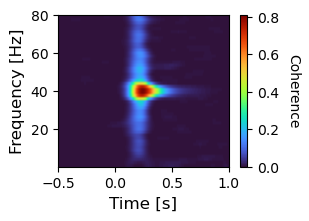

In [14]:
plt.figure(figsize=(7 / 2.54, 5 / 2.54))
plt.imshow(
    coh.real,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    extent=[-0.5, 1, 0.1, 80],
    vmin=0,
)
cbar = plt.colorbar()
cbar.set_label("Coherence", rotation=270, labelpad=15)
plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("Frequency [Hz]", fontsize=12)

plt.savefig("figures/coherece2nodes.pdf")

In [15]:
mi_fcn = get_mi("gc")

mi_fcn_time = jax.vmap(mi_fcn, in_axes=(2, 2, None, None))
mi_fcn_time_frequency = jax.vmap(mi_fcn_time, in_axes=(2, 2, None, None))

z = W[:, 0] * np.conj(W[:, 1])

dphi = jnp.stack((z.real, z.imag))

labels = np.tile(
    np.expand_dims(np.arange(0, ntrials), (1, 2)), (z.shape[1], z.shape[2])
)


MI_PHI = mi_fcn_time_frequency(dphi, labels[None], False, False)

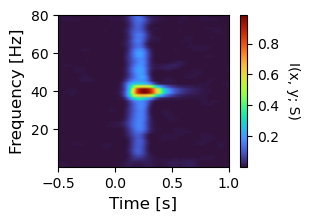

In [16]:
plt.figure(figsize=(7 / 2.54, 5 / 2.54))

plt.imshow(
    MI_PHI,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    extent=[-0.5, 1, 0.1, 80],
)

cbar = plt.colorbar()
cbar.set_label(r"I(x, y; S)", rotation=270, labelpad=15)

plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("Frequency [Hz]", fontsize=12)

plt.savefig("figures/MI2nodes.pdf")

In [127]:
from jax import custom_derivatives, dtypes, lax
from jax._src.lax.lax import _const as _lax_const
from jax._src.numpy.util import promote_args_inexact, promote_dtypes_inexact
from jax.typing import ArrayLike


def pad_to_max_shape(arr, target_shape, axis, fill_value=1):
    """
    Pad `arr` to match `target_shape` along all non-concatenation axes.
    """
    # Compute pad width for each axis
    pad_width = [
        (0, t - s) if i != axis else (0, 0)
        for i, (s, t) in enumerate(zip(arr.shape, target_shape))
    ]
    return jnp.pad(arr, pad_width, constant_values=fill_value)


def concat_fill(arrays, axis=0, fill_value=1):
    # Compute maximum shape along each dimension
    shapes = jnp.array([a.shape for a in arrays])
    target_shape = jnp.max(shapes, axis=0)

    # Pad all arrays
    padded_arrays = [
        pad_to_max_shape(a, target_shape, axis, fill_value) for a in arrays
    ]

    # Concatenate along the given axis
    return jnp.concatenate(padded_arrays, axis=axis)


def digitize_equiprobable(data, N):
    """
    Coarse-grain continuous data into N equiprobable bins (quantile-based).
    Each sample is replaced by the bin's representative (mean) value.

    Parameters:
        data (array-like): input float data (any shape)
        N (int): number of bins

    Returns:
        np.ndarray: data replaced by bin representative values
        np.ndarray: bin edges used
    """
    data = jnp.asarray(data)

    # Compute quantile-based bin edges
    quantiles = jnp.linspace(0, 1, N + 1)
    bin_edges = jnp.quantile(
        data, quantiles, axis=1
    ).T  # jnp.linspace(data.min(axis=1), data.max(axis=1), N).T#

    bin_idx = jax.vmap(jnp.digitize, in_axes=(0, 0, None))(data, bin_edges, True)

    return bin_idx, bin_edges


def xlogy(x: ArrayLike, y: ArrayLike):
    """Compute x*log(y), returning 0 for x=0.

    JAX implementation of :obj:`scipy.special.xlogy`.

    This is defined to return zero when :math:`(x, y) = (0, 0)`, with a custom
    derivative rule so that automatic differentiation is well-defined at this point.

    Args:
      x: arraylike, real-valued.
      y: arraylike, real-valued.

    Returns:
      array containing xlogy values.

    See also:
      :func:`jax.scipy.special.xlog1py`
    """
    # Note: xlogy(0, 0) should return 0 according to the function documentation.
    x, y = promote_args_inexact("xlogy", x, y)
    x_ok = x != 0.0
    return jnp.where(x_ok, lax.mul(x, lax.log(y)), jnp.zeros_like(x))


def entrBin(x: ArrayLike, deltas: ArrayLike):
    r"""The entropy function

  JAX implementation of :obj:`scipy.special.entr`.

  .. math::

     \mathrm{entr}(x) = \begin{cases}
       -x\log(x) & x > 0 \\
       0 & x = 0\\
       -\infty & \mathrm{otherwise}
     \end{cases}

  Args:
    x: arraylike, real-valued.

  Returns:
    array containing entropy values.

  See also:
    - :func:`jax.scipy.special.kl_div`
    - :func:`jax.scipy.special.rel_entr`
  """
    (x,) = promote_args_inexact("entr", x)
    if dtypes.issubdtype(x.dtype, np.complexfloating):
        raise ValueError("entr does not support complex-valued inputs.")
    return lax.select(
        lax.lt(x, _lax_const(x, 0)),
        lax.full_like(x, -np.inf),
        lax.neg(xlogy(x, x / deltas)),
    )


def entropyBin(x, N, n_bins, deltas):

    # Entropy
    uniques, counts = jnp.unique(x, return_counts=True, axis=1, size=N, fill_value=0)
    probs = counts / N

    n_states = uniques.shape[0]

    delta_per_state = jnp.prod(
        deltas[jnp.arange(deltas.shape[0])[:, None], uniques], axis=0
    )
    return entrBin(probs, delta_per_state).sum() / jnp.log(2)


def mutualInformationBin(x, y, nx_bins, ny_bins):

    #x, bin_edges_x = digitize_equiprobable(x, nx_bins)
    #y, bin_edges_y = digitize_equiprobable(y, ny_bins)

    N = x.shape[1]

    delta_bin_x = jnp.diff(bin_edges_x, axis=1)
    delta_bin_y = jnp.diff(bin_edges_y, axis=1)

    delta_bin_x = jnp.atleast_2d(delta_bin_x)
    delta_bin_y = jnp.atleast_2d(delta_bin_y)

    Hx = entropyBin(x, N, nx_bins, delta_bin_x)
    Hy = entropyBin(y, N, ny_bins, delta_bin_y)

    deltas = concat_fill([delta_bin_x, delta_bin_y], axis=0, fill_value=1)
    print(deltas.shape)
    Hxy = entropyBin(jnp.concatenate((x, y), axis=0), N, ny_bins * nx_bins, deltas)
    return Hx + Hy - Hxy

mutualInformationBin_jax = jax.vmap(mutualInformationBin, in_axes=(2, 2, None, None))
mutualInformationBin_jax2 = jax.vmap(
    mutualInformationBin_jax, in_axes=(2, 2, None, None)
)

In [128]:
dphi = jnp.stack((z.real, z.imag))

labels = np.tile(
    np.expand_dims(np.linspace(0, 100, ntrials), (1, 2)), (dphi.shape[2], dphi.shape[3])
)

x, y = dphi, labels[None]

In [129]:
x_, bin_edges_x = digitize_equiprobable( x.reshape(1, -1), 5)
y_, bin_edges_y = digitize_equiprobable( y.reshape(1, -1), ntrials)

In [130]:
x = x_.reshape(*x.shape)
y = y_.reshape(*y.shape)

In [131]:
bin_edges_y.shape

(1, 1001)

In [132]:
MI_PHI = mutualInformationBin_jax2(x, y, 5, ntrials)

(2, 1000)


ValueError: Incompatible shapes for broadcasting: shapes=[(2, 1), (3, 1000)]

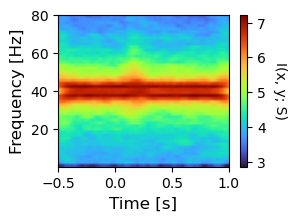

In [86]:
plt.figure(figsize=(7 / 2.54, 5 / 2.54))

plt.imshow(
    MI_PHI,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    extent=[-0.5, 1, 0.1, 80],
)

cbar = plt.colorbar()
cbar.set_label(r"I(x, y; S)", rotation=270, labelpad=15)

plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("Frequency [Hz]", fontsize=12)

plt.savefig("figures/MI2nodes.pdf")